In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import csv
import locale
from scipy.stats import randint
import joblib
locale.setlocale( locale.LC_ALL, '' )

'en_US.UTF-8'

In [5]:
def safe_log(x):
    return np.log(x + 1e-10)

In [6]:
x = 0.0
result = np.log(x)  # This will result in a warning or an error
# Compare with safe_log
safe_result = safe_log(x)  # This will not result in errors
print(result, safe_result)

-inf -23.025850929940457


/var/folders/ss/qz3br0_d1g78ct98mfd1bx7h0000gn/T/ipykernel_1615/3585201358.py:2: RuntimeWarning: divide by zero encountered in log
  result = np.log(x)  # This will result in a warning or an error


# Reading data

In [7]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [8]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1022 non-null   int64  
 1   Id             1022 non-null   int64  
 2   MSSubClass     1022 non-null   int64  
 3   MSZoning       1022 non-null   object 
 4   LotFrontage    842 non-null    float64
 5   LotArea        1022 non-null   int64  
 6   Street         1022 non-null   object 
 7   Alley          60 non-null     object 
 8   LotShape       1022 non-null   object 
 9   LandContour    1022 non-null   object 
 10  Utilities      1022 non-null   object 
 11  LotConfig      1022 non-null   object 
 12  LandSlope      1022 non-null   object 
 13  Neighborhood   1022 non-null   object 
 14  Condition1     1022 non-null   object 
 15  Condition2     1022 non-null   object 
 16  BldgType       1022 non-null   object 
 17  HouseStyle     1022 non-null   object 
 18  OverallQ

# Create a copy of the train data

In [9]:
housing = train_set.copy()

# analyze the missing values

In [10]:
all_data_na = (housing.isnull().sum() / len(housing)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(15)

,Missing Ratio
PoolQC,99.510763
MiscFeature,96.868885
Alley,94.129159
Fence,80.626223
FireplaceQu,46.966732
LotFrontage,17.612524
GarageType,5.283757
GarageYrBlt,5.283757
GarageFinish,5.283757
GarageQual,5.283757


We fill the missing values by 0 if the type of the input is an integer, and we fill ‘None’ if it’s categorical.

In [11]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    housing[col] = housing[col].fillna(0) #housing[col].mean())#0)
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass' ):
    housing[col] = housing[col].fillna('None')

For the following input variables, we fill the missing values with the most frequent value. Notice that the variable LotFrontage is of type “float”. In general, the LotFrontage of a house is more or less equal to the Neighborhood houses. Hence we group the data by “Neighborhood” and fill the missing values with a median value of the neighborhood houses.

In [12]:
housing["LotFrontage"] = housing.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
housing['MSZoning'] = housing['MSZoning'].fillna(housing['MSZoning'].mode()[0])
housing['Electrical'] = housing['Electrical'].fillna(housing['Electrical'].mode()[0])
housing['KitchenQual'] = housing['KitchenQual'].fillna(housing['KitchenQual'].mode()[0])
housing['Exterior1st'] = housing['Exterior1st'].fillna(housing['Exterior1st'].mode()[0])
housing['Exterior2nd'] = housing['Exterior2nd'].fillna(housing['Exterior2nd'].mode()[0])
housing['SaleType'] = housing['SaleType'].fillna(housing['SaleType'].mode()[0])

Feature engineering

combining features
dropping unessaciary ones
see eda 1&2 for detailed feature analysis

In [13]:
#almost all of Utilities is the same
housing = housing.drop(['Utilities'], axis=1)
#replace missing values with "Typ"
housing["Functional"] = housing["Functional"].fillna("Typ")
#combine features
housing['TotalSF'] = housing['TotalBsmtSF'] + housing['1stFlrSF'] + housing['2ndFlrSF']
housing = housing.drop('1stFlrSF', axis=1)
housing = housing.drop('TotalBsmtSF', axis=1)
# Bsmt Fin Type
housing["BsmtFinType"] = housing["BsmtFinType1"] + housing["BsmtFinType2"]
housing = housing.drop("BsmtFinType1", axis=1)
housing = housing.drop("BsmtFinType2", axis=1)
#combine conditition1 and condition2
housing['Condition'] = housing['Condition1'] + housing['Condition2'] #Condition1 has one more unique value than condition2 so hmmmm
housing = housing.drop('Condition1', axis=1)
housing = housing.drop('Condition2', axis=1)
#Fixing Exterior 2nd
housing['Exterior'] = housing['Exterior1st'] + housing["Exterior2nd"]
# Drop the 'Exterior1st' and 'Exterior2nd' columns
housing = housing.drop(['Exterior1st', 'Exterior2nd'], axis=1)
# dropped because overfitting
housing = housing.drop("Id", axis=1)
# considered irrelevant from histograms (too many 0 values)
housing = housing.drop("MSZoning", axis=1) 
housing = housing.drop("YrSold", axis=1) 
housing = housing.drop("LowQualFinSF", axis=1)
#Too many missing values
housing = housing.drop("PoolQC", axis=1)
housing = housing.drop("Fence", axis=1)
housing = housing.drop("MiscFeature", axis=1)
housing = housing.drop("FireplaceQu", axis=1)
housing = housing.drop("Alley", axis=1)

housing = housing.drop("LotFrontage", axis=1)

#extra changes not sure ab these
housing = housing.drop("MasVnrType", axis=1)
housing = housing.drop("GarageFinish", axis=1)
housing = housing.drop("GarageQual", axis=1)
housing = housing.drop("GarageCond", axis=1)
housing = housing.drop("BsmtFinSF1", axis=1)
housing = housing.drop("BsmtFinSF2", axis=1)
housing = housing.drop("Heating", axis=1)
housing = housing.drop("LandSlope", axis=1)
housing = housing.drop("ExterCond", axis=1)
#
# changes to data

corr_matrix = housing.corr(numeric_only=True)
list_col = list(corr_matrix)
corr_matrix["SalePrice"]

Unnamed: 0      -0.035452
MSSubClass      -0.076696
LotArea          0.257302
OverallQual      0.789634
OverallCond     -0.083465
YearBuilt        0.542773
YearRemodAdd     0.510283
MasVnrArea       0.469071
BsmtUnfSF        0.218188
2ndFlrSF         0.308750
GrLivArea        0.719985
BsmtFullBath     0.226761
BsmtHalfBath    -0.015511
FullBath         0.570163
HalfBath         0.284235
BedroomAbvGr     0.175139
KitchenAbvGr    -0.132590
TotRmsAbvGrd     0.555989
Fireplaces       0.475610
GarageYrBlt      0.260569
GarageCars       0.634395
GarageArea       0.626319
WoodDeckSF       0.308526
OpenPorchSF      0.317960
EnclosedPorch   -0.128401
3SsnPorch        0.032842
ScreenPorch      0.103018
PoolArea         0.116425
MiscVal         -0.029293
MoSold           0.060779
SalePrice        1.000000
TotalSF          0.785196
Name: SalePrice, dtype: float64

no more missing values

In [14]:
all_data_na = (housing.isnull().sum() / len(housing)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


# Collinearity

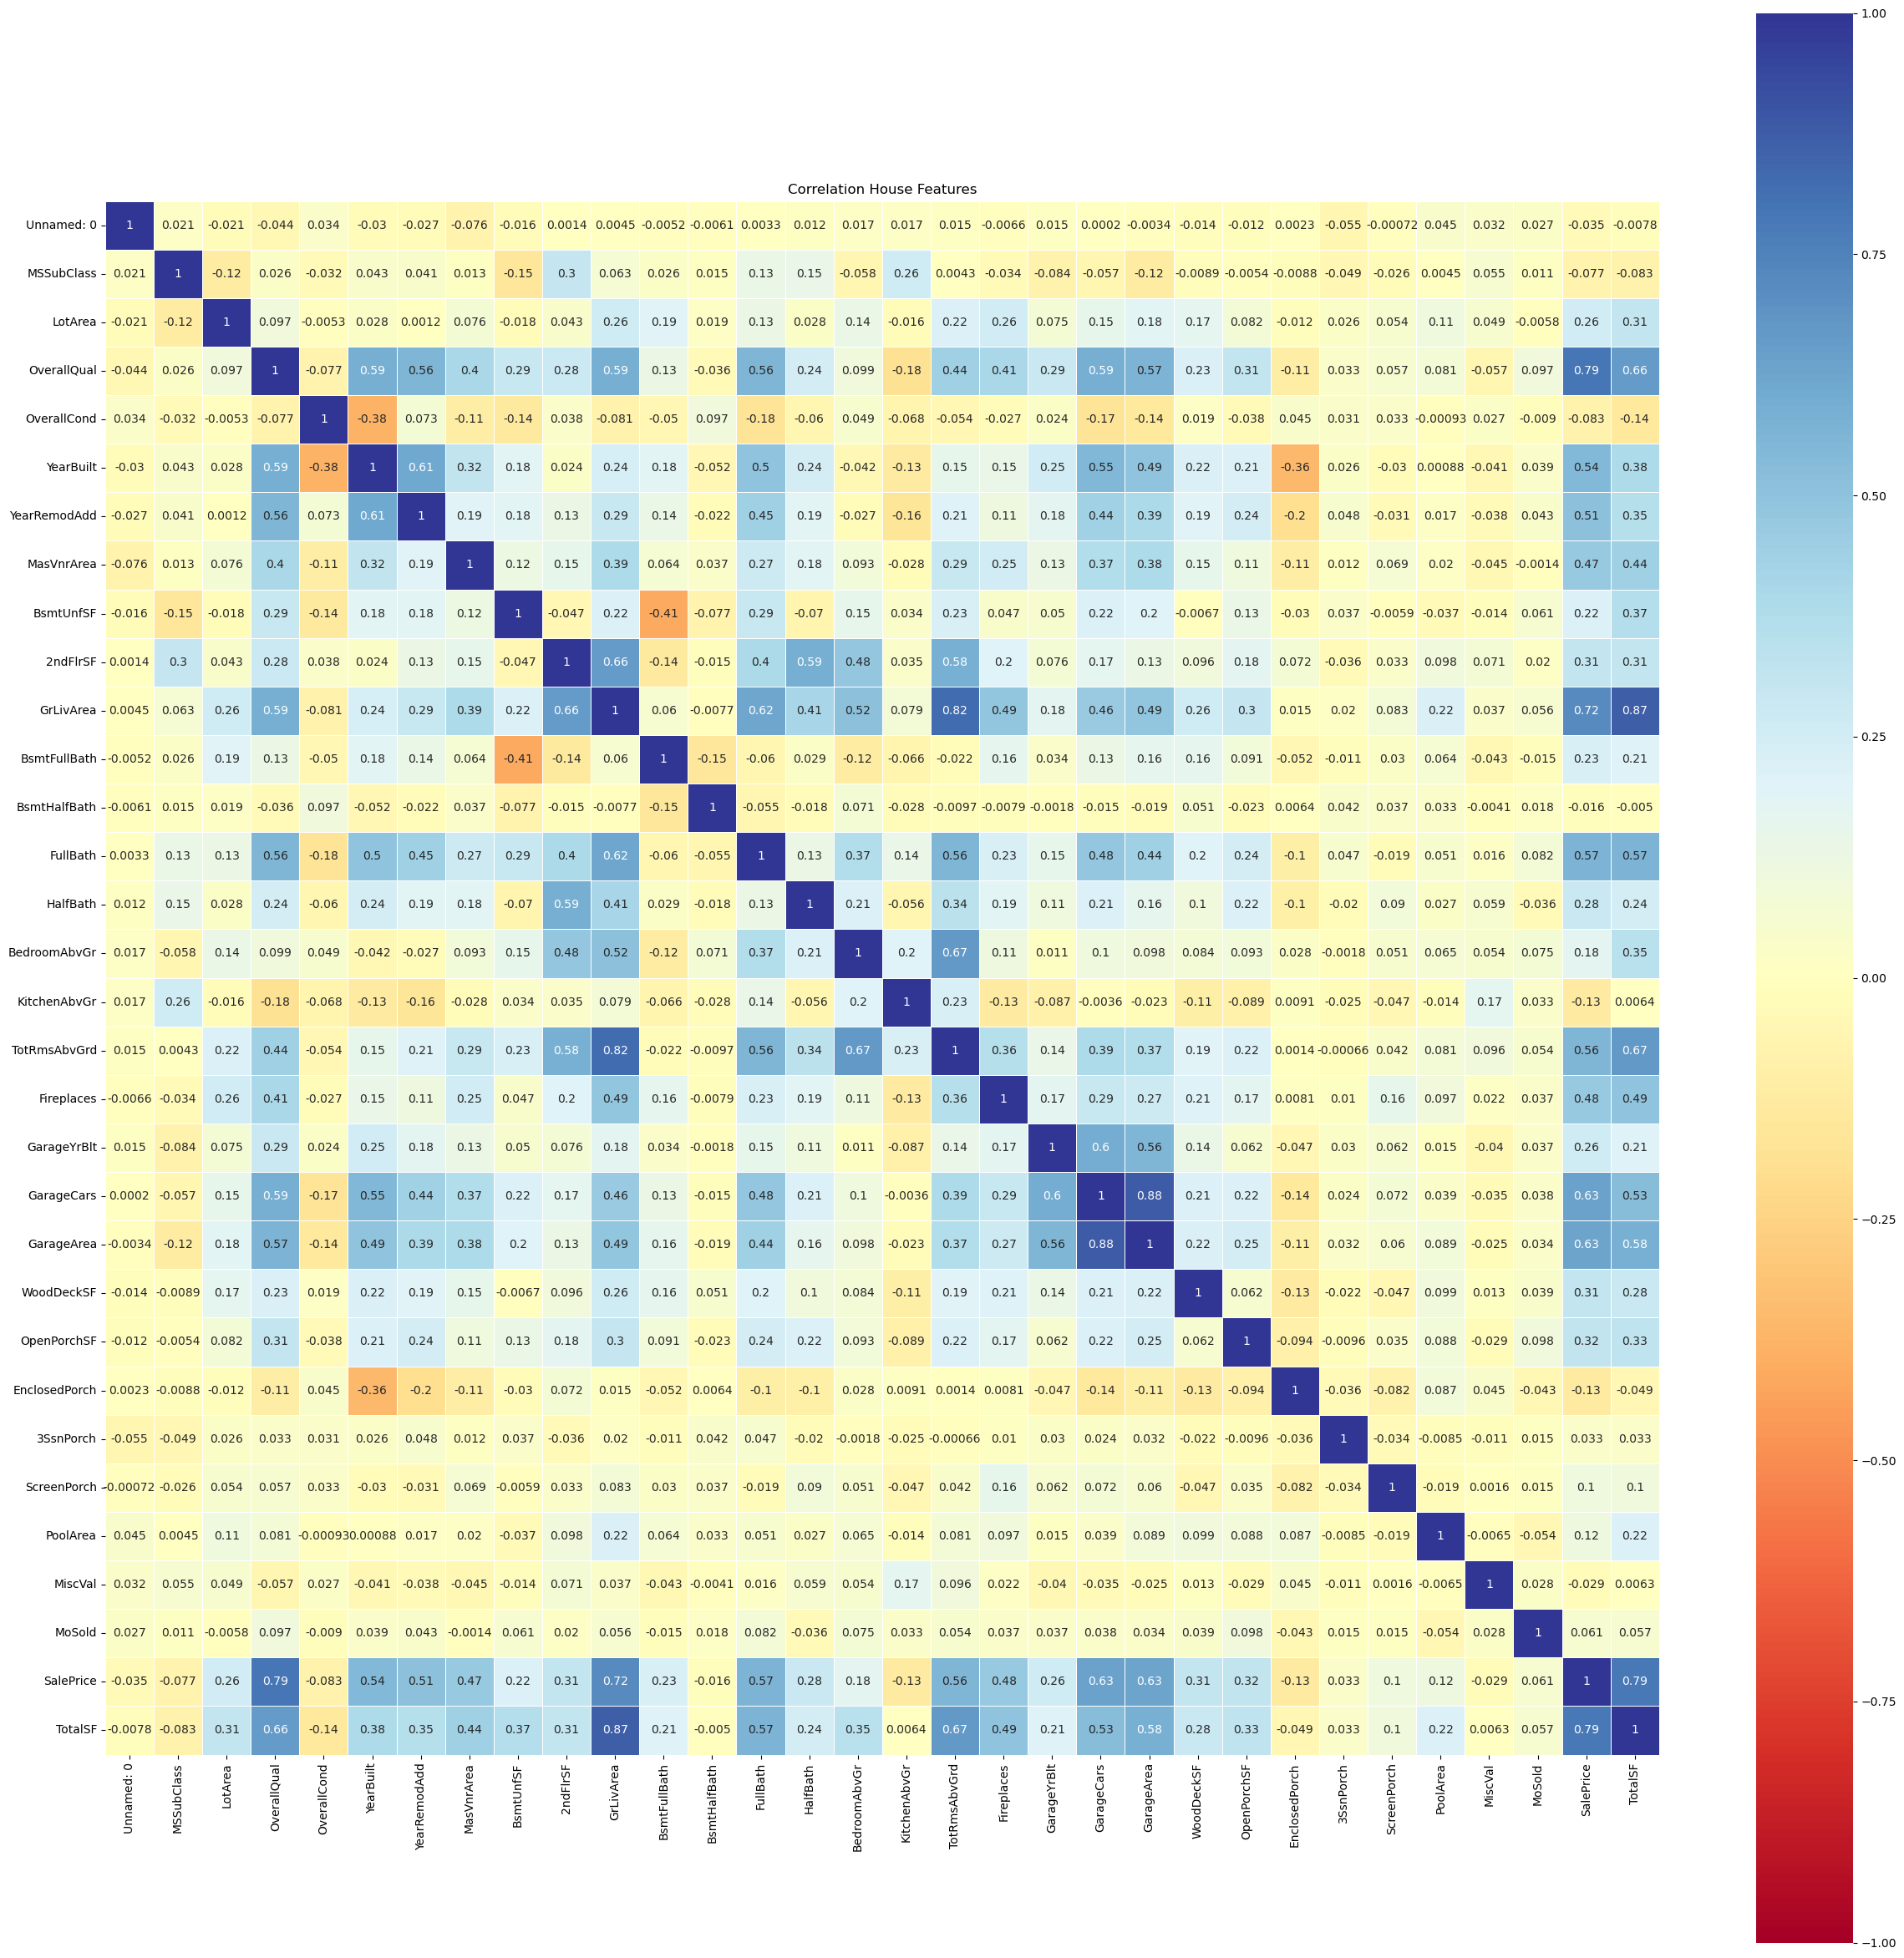

In [15]:
#Get dataframe of only numberic columns
import matplotlib.pyplot as plt 
import seaborn as sns
dfnumeric = housing._get_numeric_data()
corrmat = dfnumeric.corr()

f, ax = plt.subplots(figsize = (30,30))
sns.heatmap(corrmat, vmin = -1, vmax = 1, square=True, annot = True, cmap = 'RdYlBu', linewidths =.5)
plt.title('Correlation House Features')

plt.show();

# Outliers

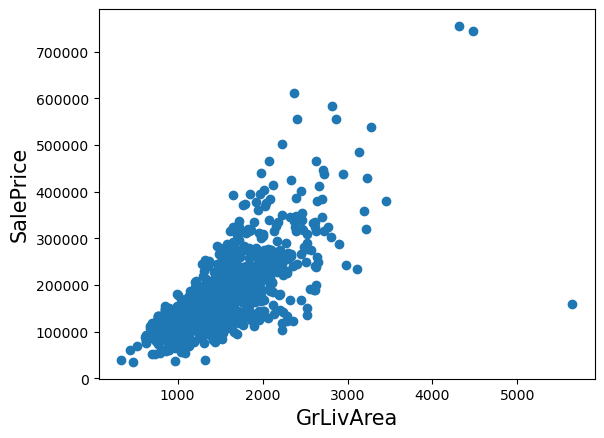

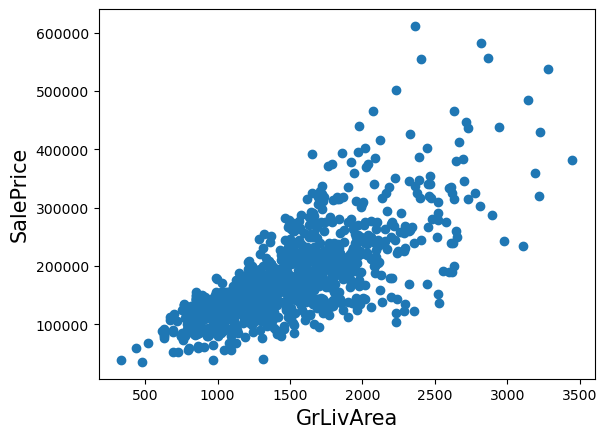

In [16]:
fig, ax = plt.subplots()
ax.scatter(x = housing['GrLivArea'], y = housing['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()


# Replace outliers with the mean of "GrLivArea" excluding outliers
mean_grlivarea = np.median(housing.loc[housing['GrLivArea'] <= 4000, 'GrLivArea'])
housing.loc[housing['GrLivArea'] > 4000, 'GrLivArea'] = mean_grlivarea
# Replace outliers in 'SalePrice' with the median of 'SalePrice' excluding outliers
median_saleprice = np.median(housing.loc[housing['SalePrice'] <= 700000, 'SalePrice'])
housing.loc[housing['SalePrice'] > 700000, 'SalePrice'] = median_saleprice
        
fig, ax = plt.subplots()
ax.scatter(x = housing['GrLivArea'], y = housing['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

# Cleaning Data
dropping all values with lower than 0.5 correlation leaves us with 47 values -printed cols that we dropped as a result of this.

should have 35 features total

In [17]:
housing_labels = pd.DataFrame(train_set["SalePrice"].copy())
housing = housing.drop("SalePrice", axis=1)
ids = test_set["Id"]
#drop cols with <0.5 correlation
for k in range(len(list_col)):
    if corr_matrix["SalePrice"].iloc[k] < 0.5:
        housing = housing.drop(f"{list_col[k]}", axis=1)
        print(f"{list_col[k]}" + " with " + str(corr_matrix["SalePrice"].iloc[k]))
print(f"Total features : {len(list(housing.columns))}")

Unnamed: 0 with -0.035451920684353995
MSSubClass with -0.07669617067875223
LotArea with 0.25730190142911336
OverallCond with -0.08346535992194823
MasVnrArea with 0.469070971501225
BsmtUnfSF with 0.21818764271022253
2ndFlrSF with 0.30874980631778254
BsmtFullBath with 0.2267610853917443
BsmtHalfBath with -0.015511114237539503
HalfBath with 0.2842353431616688
BedroomAbvGr with 0.17513906315640435
KitchenAbvGr with -0.13258996953374586
Fireplaces with 0.47560982092279636
GarageYrBlt with 0.2605690324885031
WoodDeckSF with 0.30852599700676614
OpenPorchSF with 0.3179604418880326
EnclosedPorch with -0.1284013373619787
3SsnPorch with 0.0328420434030211
ScreenPorch with 0.10301841646960345
PoolArea with 0.11642516617770528
MiscVal with -0.029292564216495728
MoSold with 0.060779377171947264
Total features : 35


In [18]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Street         1022 non-null   object
 1   LotShape       1022 non-null   object
 2   LandContour    1022 non-null   object
 3   LotConfig      1022 non-null   object
 4   Neighborhood   1022 non-null   object
 5   BldgType       1022 non-null   object
 6   HouseStyle     1022 non-null   object
 7   OverallQual    1022 non-null   int64 
 8   YearBuilt      1022 non-null   int64 
 9   YearRemodAdd   1022 non-null   int64 
 10  RoofStyle      1022 non-null   object
 11  RoofMatl       1022 non-null   object
 12  ExterQual      1022 non-null   object
 13  Foundation     1022 non-null   object
 14  BsmtQual       1022 non-null   object
 15  BsmtCond       1022 non-null   object
 16  BsmtExposure   1022 non-null   object
 17  HeatingQC      1022 non-null   object
 18  CentralAir     1022 non-null

# Preprocessing
Use one hot encoder for categorical features then use standard scaler for numerical features to make them between 0-1 as well.

In [19]:
text_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
num_norm_pipeline = make_pipeline(StandardScaler())
preprocess = ColumnTransformer([
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)

# Classifier K means
determining the optimal amount of clusters

In [22]:

from sklearn.cluster import KMeans
# Classifier pipeline (k-means)
k_means_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('kmeans', KMeans(random_state=42))
])
# Parameters for grid search
param_grid = {
    'kmeans__n_clusters': [2, 3, 4, 5, 6],  #range of clusters
}
#Grid search with k-fold cross-validation
grid_search = GridSearchCV(k_means_pipeline, param_grid, cv=5)  # Adjust cv as needed
#Fit the pipeline with grid search on your data
grid_search.fit(housing, housing_labels)
#Access the best parameters and the fitted model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(best_params)


/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

{'kmeans__n_clusters': 6}


/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Running kmeans with 5 clusters because thats what grid search gave us.

In [23]:
# KMeans pipeline
k_means_pipeline = make_pipeline(preprocess, KMeans(n_clusters=5))  

# Fit KMeans and get cluster assignments
cluster_assignments = k_means_pipeline.fit_predict(housing)

# Add cluster assignments to the original DataFrame
housing_clustered = pd.concat([housing, pd.Series(cluster_assignments, name='Cluster')], axis=1)

# Print the DataFrame with cluster assignments
print(housing_clustered['Cluster'])

0       4
1       0
2       3
3       4
4       3
       ..
1017    2
1018    2
1019    3
1020    3
1021    3
Name: Cluster, Length: 1022, dtype: int32


/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Linear Regression
used for testing purposes

In [24]:
import locale

# Set the locale
locale.setlocale(locale.LC_ALL, '')
# Linear regression pipeline
lin_reg_pipeline = make_pipeline(preprocess, LinearRegression())
# Loop through each cluster
for i in range(5):  # Assuming 5? clusters
    # Filter data for the current cluster
    cluster_data = housing_clustered[housing_clustered['Cluster'] == i]
    X_cluster = cluster_data.drop(columns=['Cluster'])  # Features for the current cluster
    y_cluster = housing_labels.loc[cluster_data.index]  # Replace 'your_target_column' with your actual target column
    
    # Fit the linear regression model for the current cluster
    lin_reg_pipeline.fit(X_cluster, y_cluster)

    # Make predictions for the entire dataset
    housing_predictions = lin_reg_pipeline.predict(housing)
    
    # Print some predictions for the current cluster
    for idx in cluster_data.index[:10]:  # Print for the first 10 rows in the cluster
        real_value_str = locale.currency(float(y_cluster.loc[idx].values[0]), grouping=True)
        prediction_value_str = locale.currency(float(housing_predictions[cluster_data.index.get_loc(idx)].round(2)), grouping=True)

        print(f"Cluster {i}, Real value: {real_value_str}, Prediction: {prediction_value_str}")

Cluster 0, Real value: $108,000.00, Prediction: $309,992.29
Cluster 0, Real value: $100,000.00, Prediction: $103,758.17
Cluster 0, Real value: $153,575.00, Prediction: $138,735.41
Cluster 0, Real value: $84,500.00, Prediction: $223,699.60
Cluster 0, Real value: $113,000.00, Prediction: $155,618.72
Cluster 0, Real value: $64,500.00, Prediction: $231,108.50
Cluster 0, Real value: $135,900.00, Prediction: $206,458.09
Cluster 0, Real value: $112,000.00, Prediction: $186,370.00
Cluster 0, Real value: $85,500.00, Prediction: $279,254.76
Cluster 0, Real value: $93,000.00, Prediction: $152,806.21
Cluster 1, Real value: $250,000.00, Prediction: $191,119.89
Cluster 1, Real value: $228,000.00, Prediction: -$143,054.71
Cluster 1, Real value: $315,750.00, Prediction: $50,187.62
Cluster 1, Real value: $290,000.00, Prediction: $143,604.45
Cluster 1, Real value: $465,000.00, Prediction: -$175,500.76
Cluster 1, Real value: $248,328.00, Prediction: $335,058.04
Cluster 1, Real value: $290,000.00, Predict

In [25]:
lin_reg = Pipeline([("pre", preprocess),  ("reg", LinearRegression())])
lin_reg.fit(housing, housing_labels)

housing_predictions = lin_reg.predict(housing)
for k in range(10):
    print(f"Real value: {locale.currency(housing_labels.iloc[k].values[0], grouping=True)}, Prediction: {locale.currency(housing_predictions[k][0].round(2), grouping=True)}")


Real value: $219,500.00, Prediction: $227,943.05
Real value: $108,000.00, Prediction: $115,205.31
Real value: $176,000.00, Prediction: $197,781.80
Real value: $197,000.00, Prediction: $182,760.88
Real value: $129,900.00, Prediction: $108,431.16
Real value: $187,500.00, Prediction: $207,587.88
Real value: $167,000.00, Prediction: $180,263.00
Real value: $165,000.00, Prediction: $174,877.75
Real value: $193,879.00, Prediction: $197,706.96
Real value: $157,500.00, Prediction: $143,683.52


In [26]:
lin_rmse = mean_squared_error(safe_log(housing_labels), safe_log(housing_predictions), squared=False)
print(lin_rmse)

0.1331753843351749


In [27]:
housing_predictions2 = lin_reg.predict(housing)
lin_rmse2 = mean_squared_error(housing_labels, housing_predictions2, squared=False)
print(lin_rmse2)

21572.467024076635


In [28]:
for k in range(10):
    print(f"Real value: {locale.currency(housing_labels.iloc[k].values[0], grouping=True)}, Prediction: {locale.currency(housing_predictions2[k][0].round(2), grouping=True)}")

Real value: $219,500.00, Prediction: $227,943.05
Real value: $108,000.00, Prediction: $115,205.31
Real value: $176,000.00, Prediction: $197,781.80
Real value: $197,000.00, Prediction: $182,760.88
Real value: $129,900.00, Prediction: $108,431.16
Real value: $187,500.00, Prediction: $207,587.88
Real value: $167,000.00, Prediction: $180,263.00
Real value: $165,000.00, Prediction: $174,877.75
Real value: $193,879.00, Prediction: $197,706.96
Real value: $157,500.00, Prediction: $143,683.52


# Using Multiple Models
LR

Bagging

RandomForest

Boosting

In [29]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression #
from sklearn.ensemble import BaggingRegressor #
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor #


# Assuming 'SalePrice' is your target column
y = housing_labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(housing, y, test_size=0.2, random_state=42)

# # Neural network model from scikit-learn
# nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)

# # Support Vector Machine (SVM) model
# svm_model = SVR()

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#___ model
lr_model = LinearRegression() #
base_estimator = DecisionTreeRegressor(random_state=42) #
bagging_model = BaggingRegressor(base_estimator, n_estimators=10, random_state=42) #
base_estimator = DecisionTreeRegressor(max_depth=3, random_state=42) #
boost_model = AdaBoostRegressor(base_estimator, n_estimators=50, learning_rate=0.1, random_state=42) #


"""

# Loop through each cluster
for i in range(5):
    # Filter data for the current cluster
    cluster_data = housing_clustered[housing_clustered['Cluster'] == i]
    X_cluster = cluster_data.drop(columns=['Cluster'])  # Features for the current cluster
    y_cluster = housing_labels.loc[cluster_data.index]

    # Preprocess the data
    X_train_processed = preprocess.fit_transform(X_train)
    X_cluster_processed = preprocess.transform(X_cluster)

    # Train the neural network model for the current cluster
    lr_model.fit(X_train_processed, y_train)

    # Train the SVM model for the current cluster
    bagging_model.fit(X_train_processed, y_train)

    # Train the Random Forest model for the current cluster
    rf_model.fit(X_train_processed, y_train)
    
    #Train the __ model for the current cluster
    boost_model.fit(X_train_processed.toarray(), y_train) #
    

    # Make predictions for the entire dataset using each model
    lr_predictions = lr_model.predict(X_cluster_processed)
    lr_predictions = lr_predictions.T[0]
    bagging_predictions = bagging_model.predict(X_cluster_processed)
    rf_predictions = rf_model.predict(X_cluster_processed)
    boost_predictions = boost_model.predict(X_cluster_processed.toarray()) #
    

    # Print some predictions for the current cluster
    for idx in cluster_data.index[:10]:
        print(f"Cluster {i}, Real value: {locale.currency(y_cluster.loc[idx].values[0], grouping=True)}, "
              f"LR Prediction: {locale.currency(lr_predictions[cluster_data.index.get_loc(idx)].round(2), grouping=True)}, "
              f"Bagging Prediction: {locale.currency(bagging_predictions[cluster_data.index.get_loc(idx)].round(2), grouping=True)}, "
              f"RF Prediction: {locale.currency(rf_predictions[cluster_data.index.get_loc(idx)].round(2), grouping=True)}, "
              f"Boost Prediction: {locale.currency(boost_predictions[cluster_data.index.get_loc(idx)].round(2), grouping=True)}") #
"""


'\n\n# Loop through each cluster\nfor i in range(5):\n    # Filter data for the current cluster\n    cluster_data = housing_clustered[housing_clustered[\'Cluster\'] == i]\n    X_cluster = cluster_data.drop(columns=[\'Cluster\'])  # Features for the current cluster\n    y_cluster = housing_labels.loc[cluster_data.index]\n\n    # Preprocess the data\n    X_train_processed = preprocess.fit_transform(X_train)\n    X_cluster_processed = preprocess.transform(X_cluster)\n\n    # Train the neural network model for the current cluster\n    lr_model.fit(X_train_processed, y_train)\n\n    # Train the SVM model for the current cluster\n    bagging_model.fit(X_train_processed, y_train)\n\n    # Train the Random Forest model for the current cluster\n    rf_model.fit(X_train_processed, y_train)\n    \n    #Train the __ model for the current cluster\n    boost_model.fit(X_train_processed.toarray(), y_train) #\n    \n\n    # Make predictions for the entire dataset using each model\n    lr_predictions =

# Test data prediction
Transforms the test data

In [30]:
def test_data_prediction(test):
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        test[col] = test[col].fillna(0)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass' ):
        test[col] = test[col].fillna('None')
    test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
    test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])
    test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
    test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
    test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
    test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])
    #almost all of Utilities is the same
    test = test.drop(['Utilities'], axis=1)
    #replace missing values with "Typ"
    test["Functional"] = test["Functional"].fillna("Typ")
    #combine features
    test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
    test = test.drop('1stFlrSF', axis=1)
    test = test.drop('TotalBsmtSF', axis=1)
    # Bsmt Fin Type
    test["BsmtFinType"] = test["BsmtFinType1"] + test["BsmtFinType2"]
    test = test.drop("BsmtFinType1", axis=1)
    test = test.drop("BsmtFinType2", axis=1)
    #combine conditition1 and condition2
    test['Condition'] = test['Condition1'] + test['Condition2'] #Condition1 has one more unique value than condition2 so hmmmm
    test = test.drop('Condition1', axis=1)
    test = test.drop('Condition2', axis=1)
    #Fixing Exterior 2nd
    test['Exterior'] = test['Exterior1st'] + test["Exterior2nd"]
    # Drop the 'Exterior1st' and 'Exterior2nd' columns
    test = test.drop(['Exterior1st', 'Exterior2nd'], axis=1)
    # dropped because overfitting
    test = test.drop("Id", axis=1)
    # considered irrelevant from histograms (too many 0 values)
    test = test.drop("MSZoning", axis=1) 
    test = test.drop("YrSold", axis=1) 
    test = test.drop("LowQualFinSF", axis=1)
    #Too many missing values
    test = test.drop("PoolQC", axis=1)
    test = test.drop("Fence", axis=1)
    test = test.drop("MiscFeature", axis=1)
    test = test.drop("FireplaceQu", axis=1)
    test = test.drop("Alley", axis=1)
    test = test.drop("LotFrontage", axis=1)
    #extra changes not sure ab these
    test = test.drop("MasVnrType", axis=1)
    test = test.drop("GarageFinish", axis=1)
    test = test.drop("GarageQual", axis=1)
    test = test.drop("GarageCond", axis=1)
    test = test.drop("BsmtFinSF1", axis=1)
    test = test.drop("BsmtFinSF2", axis=1)
    test = test.drop("Heating", axis=1)
    test = test.drop("LandSlope", axis=1)
    test = test.drop("ExterCond", axis=1)
    
    # Replace outliers with the mean of "GrLivArea" excluding outliers
    mean_grlivarea = np.median(test.loc[test['GrLivArea'] <= 4000, 'GrLivArea'])
    test.loc[test['GrLivArea'] > 4000, 'GrLivArea'] = mean_grlivarea
    # Replace outliers in 'SalePrice' with the median of 'SalePrice' excluding outliers
    median_saleprice = np.median(test.loc[test['SalePrice'] <= 700000, 'SalePrice'])
    test.loc[test['SalePrice'] > 700000, 'SalePrice'] = median_saleprice
    corr_matrix = test.corr(numeric_only=True)
    list_col = list(corr_matrix)
    
    for k in range(len(list_col)):
        if not list_col[k] in housing.columns and not list_col[k] == 'SalePrice':
            test = test.drop(f"{list_col[k]}", axis=1)
        #if #not k in housing:#corr_matrix["SalePrice"].iloc[k] < 0.5:
            #test = test.drop(f"{list_col[k]}", axis=1)
    #print(f"Total features : {len(list(test.columns))}")
    #print(test.info())
    
    all_data_na = (test.isnull().sum() / len(test)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    print(missing_data.head())
    return test

makes a prediction on the test data using the trained best functions

Currently training the model with the train data.

In [72]:
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

y_train = housing_labels
X_train = housing

# Base models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
svm_model = SVR()
lr_model = LinearRegression() 
base_estimator = DecisionTreeRegressor(random_state=42) 
bagging_model = BaggingRegressor(base_estimator, n_estimators=10, random_state=42) 
base_estimator1 = DecisionTreeRegressor(max_depth=3, random_state=42) 
boost_model = AdaBoostRegressor(base_estimator1, n_estimators=50, learning_rate=0.1, random_state=42)

knn_model = KNeighborsRegressor(n_neighbors=5) 

base_estimator3 = DecisionTreeRegressor(max_depth=3, random_state=42) 
boost_model3 = AdaBoostRegressor(base_estimator3, n_estimators=50, learning_rate=0.1, random_state=42)



# StackingRegressor
stacked_model = StackingRegressor(
    estimators=[('rf', rf_model), ('svm', svm_model), ('boost', boost_model), ('nn', nn_model), ('bagging', bagging_model)],
    final_estimator= MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42),
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

# Preprocess the data
X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = test_data_prediction(test_set)
y_true = X_test_processed['SalePrice']
X_test_processed = X_test_processed.drop('SalePrice', axis=1)

#X_test_processed = test_data_prediction(test_set)

X_test_processed = preprocess.transform(X_test_processed)


#print(str(X_train_processed.shape[0]))
#print(str(X_test_processed.shape[0]))
#print(y_train)
# Train the stacked model
stacked_model.fit(X_train_processed, y_train)

print("Hey!")

# Make predictions on the test set
stacked_predictions = stacked_model.predict(X_test_processed)
print("Eh?")
# Calculate MSE
mse_stacked = mean_squared_error(y_true, stacked_predictions)

# Print MSE
print(f"Stacked Model MSE: {mse_stacked}")

output_df = pd.DataFrame({
    'Stacked_Predictions': stacked_predictions
})

output_df.to_csv('stacked_predictions.csv', index=False)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/knuckles/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  w

Hey!
Eh?
Stacked Model MSE: 796798682.3150682


fit on the test set.

In [34]:
# stacked_model.fit(X_test_processed, y_true)
# # Make predictions on the test set
# stacked_predictions = stacked_model.predict(X_test_processed)
# # Calculate MSE
# mse_stacked = mean_squared_error(y_true, stacked_predictions)
# # Print MSE
# print(f"Stacked Model MSE: {mse_stacked}")

# Whats the best?
LR, NN, SVM, RF with LR estimator = 839919103.2733352

Bagging, NN, SVM, RF with LR estimator = 825045474.5730863

Boost, NN, SVM, RF with LR estimator = 813555444.3600465

knn, NN, SVM, RF with LR estimator = 983577117.9678292

LR, NN, bagging, RF with LR estimator = 832476378.0696818

LR, NN, boost, RF with LR estimator = 818345934.6566923

LR, NN, knn, RF with LR estimator = 992847447.951081

LR, svm, boost, RF with LR estimator = 916530632.3252847

LR, bagging, boost, RF with LR estimator = 906961418.6663653

LR, knn, boost, RF with LR estimator = 1062093062.9223564

LR, nn, boost, bagging with LR estimator = 815871365.2188373

LR, svm, boost, bagging with LR estimator = 928628272.0053678

LR, knn, boost, bagging with LR estimator = 1047857052.3865746

nn, svm, boost, RF with NN estimator = 834348672.8862668

nn, svm, boost, RF with svm estimator = 5931878517.044559

LR, bagging, boost, RF with RF estimator = 1026363545.8587339

nn, svm, boost, RF with bagging estimator = 1038003468.8112102

nn, svm, boost, RF with boost estimator = 967945562.5261328

nn, svm, boost, RF with knn estimator = 1001113085.2812784

nn, svm, boost, RF, LR with LR estimator = 817370615.7316202

nn, svm, boost, RF, bagging with LR estimator = 804845068.5160588

nn, svm, boost, RF, knn with LR estimator = 942189932.4877803

nn, svm, boost, RF, bagging, lr with LR estimator = 808723784.0666702

nn, svm, boost, RF, bagging, knn with LR estimator = 917193040.2437911

nn, svm, boost, RF, LR, knn with LR estimator = 950107001.6987146

nn, svm, boost, RF, knn, svm, nn with LR estimator = 925492982.3954201



nn, svm, boost, RF, bagging with LR estimator is the best.
Now try it with other final regressors:

nn, svm, boost, RF, bagging with rf estimator = 995580364.3081722
nn, svm, boost, RF, bagging with nn estimator = 796798682.3150682
nn, svm, boost, RF, bagging with svm estimator = 5931984411.28212
nn, svm, boost, RF, bagging with boost estimator = 997417460.2524041
nn, svm, boost, RF, bagging with bagging estimator = 1013733094.2338583
nn, svm, boost, RF, bagging with knn estimator = 1002423390.9082193

nn, svm, boost, RF, bagging with nn estimator is the best!